In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pdb 

pd.set_option('display.max_columns', 100)
%matplotlib inline

In [2]:
choc = pd.read_csv('flavors_of_cacao.csv')
choc.shape

(1795, 9)

In [35]:
choc.head(2)

,maker,orig_of_bar,review_date,perc_cocoa,maker_loc,rating,bean_type,orig_of_bean
0,A. Morin,Agua Grande,2016,63,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,2015,70,France,2.75,Blend,Togo


In [4]:
# REF is just a number (smaller=earlier) relating to when the review was entered, date suffices
choc.drop(columns="REF", inplace=True)

# Do a little reworking of column names so they're less unwieldy
orig_cols = choc.columns
new_cols = ['maker', 'orig_of_bar', 'review_date', 'perc_cocoa',
            'maker_loc', 'rating', 'bean_type', 'orig_of_bean']
choc = choc.rename(columns=dict(zip(orig_cols, new_cols)))
choc.head(2)

,maker,orig_of_bar,review_date,perc_cocoa,maker_loc,rating,bean_type,orig_of_bean
0,A. Morin,Agua Grande,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,2015,70%,France,2.75,,Togo


In [39]:
# much of this will be NaN, but much is usable too; overall look at things
choc.describe(include='all')

,maker,orig_of_bar,review_date,perc_cocoa,maker_loc,rating,bean_type,orig_of_bean
count,1774,1774,1774.000000,1774.000000,1774,1774.000000,1774,1774
unique,403,1022,NaN,NaN,47,NaN,8,97
top,Soma,Madagascar,NaN,NaN,U.S.A.,NaN,Blend,Venezuela
freq,47,56,NaN,NaN,763,NaN,941,215
mean,NaN,NaN,2012.291432,71.735626,NaN,3.185457,NaN,NaN
std,NaN,NaN,2.922416,6.300924,NaN,0.479257,NaN,NaN
min,NaN,NaN,2006.000000,46.000000,NaN,1.000000,NaN,NaN
25%,NaN,NaN,2010.000000,70.000000,NaN,3.000000,NaN,NaN
50%,NaN,NaN,2013.000000,70.000000,NaN,3.250000,NaN,NaN
75%,NaN,NaN,2015.000000,75.000000,NaN,3.500000,NaN,NaN


## There's a single NaN in both bean type and origin

In [6]:
# Looks like this is one of the top makers, and a good rating.  Going to fill it in.
choc["bean_type"] = choc["bean_type"].fillna("Blend")
#choc[choc["bean_type"].isnull()]                # there, got it

In [7]:
# where's the NaN in origin?
#choc[choc["orig_of_bean"].isnull()]
#choc.loc[(choc["maker"]=="Mast Brothers")]

Ok, the only NaN in the 'maker' column is from Mast Brothers, and it's Trinitario; their other Trinitarios all originate in Venezuela, so I'm replacing the NaN with Venezuela

In [8]:
choc["orig_of_bean"] = choc["orig_of_bean"].fillna("Venezuela")
#choc[choc["orig_of_bean"].isnull()]              # there, that worked

In [9]:
# Let's see what ratings of 4 or better look like
choc.loc[choc.rating >= 4.0].nunique()

maker           45
orig_of_bar     87
review_date     11
perc_cocoa      17
maker_loc       17
rating           2
bean_type       15
orig_of_bean    31
dtype: int64

# A question is already forming: 
### What factors are common in the best rated bars, such as percent of cocoa or bean type (or origin, etc)?  How can these be tweaked to aim for a high rating?
Data cleaning first though.

In [33]:
# I don't think I'll mess with these, they look ok
#choc["maker"].unique()

The cell below has a lot of commenting out; I had to look at a few different things, and rather than displaying the output for each, I just used commenting.  

It looks like the vast majority of the empty 'orig_of_bean' fields are blends, so I'm going to fill them all in as 'Various'; I think I'll also fill in empty 'bean_type' fields all as 'Blend' too.

In [11]:
# We have a LOT of empty fields here, 887 of them
#print(choc["bean_type"].value_counts())
#print(choc["orig_of_bean"].value_counts())
#print(choc["orig_of_bean"].sort_values().unique())
choc.loc[choc["orig_of_bean"].str.len() == 1].head(10)  # there are actually 73 of these, remove head() to see

,maker,orig_of_bar,review_date,perc_cocoa,maker_loc,rating,bean_type,orig_of_bean
77,Amedei,Nine,2007,75%,Italy,4.00,Blend,
85,Amedei,Toscano Black,2007,63%,Italy,3.50,Blend,
86,Amedei,Toscano Black,2006,70%,Italy,5.00,Blend,
87,Amedei,Toscano Black,2006,66%,Italy,4.00,Blend,
144,Bahen & Co.,Houseblend,2015,80%,Australia,3.25,,
148,Bahen & Co.,Houseblend,2012,70%,Australia,2.50,Blend,
182,Bernachon,Nature,2012,55%,France,2.75,,
214,Blanxart,Organic Dark,2009,72%,Spain,2.75,,
245,Bonnat,One Hundred,2006,100%,France,1.50,,
277,Burnt Fork Bend,Blend,2014,72%,U.S.A.,3.25,Blend,


In [31]:
def clean_names(df, col, patterns):
    """ 
    Cleans up names in a specified dataframe.column, according to patterns
    Patterns are a tuple of lists: ([regex, replacement], [...], etc)
    replace() happens IN PLACE
    """
    for pattern, replacement in patterns:
        df[col] = df[col].str.replace(pattern, replacement)
        
# these are names of length one, meaning empty; they're all LIKELY blends from a variety of origins
choc.loc[choc["orig_of_bean"].str.len() == 1, "orig_of_bean"] = "VARIOUS"

# patterns to be cleaned up
patterns = ([r"D(|om(in(ican)?)?) ?R(|ep(ub(li(c)?)?)?)\b", "Dominican Republic"],
            [r"Mad\b", "Madagascar"],
            [r"Ven(ez(uel)?)?\b", "Venezuela"],
            [r"Mex\b", "Mexico"],
            [r"Guat\b", "Guatemala"],
            [r"Nic\b", "Nicaragua"],
            [r"Ecu(ad)?\b", "Ecuador"],
            [r"Haw\b", "Hawaii"],
            [r"PNG\b", "Papua New Guinea"],
            [r"Gre\b", "Grenada"],
            [r"( &|\w/)", ","],
            [r",\b", ", "],
            [r"S \b", "South "],
            [r"Brasil\b", "Brazil"],
            [r".", ""])

# MUST RUN TWICE FOR CORRECT OUTPUT
clean_names(choc, "orig_of_bean", patterns)

# There, all cleaned up; uncomment below to see cleaned up names
#choc["orig_of_bean"].sort_values().value_counts().head(50)

In [13]:
# Cleaning to do in "maker_loc", misspellings and such
patterns = ([r"Niacragua\b", "Nicaragua"],
            [r"Eucador\b", "Ecuador"],
            [r"Domincan Republic\b", "Dominican Republic"],
            [r"U.K.", "England"],
            [r"Amsterdam\b", "Holland"])

clean_names(choc, "maker_loc", patterns)

In [14]:
# There are a variety of duplicates and other corrections here; I'm choosing to combine the various subtypes
# within a larger type into the single larger type ie: 'Forastero (Nacional)' becomes just 'Forastero'
# Blends specifically listing their varietals will be lumped in with 'Blends'
choc.loc[choc["bean_type"].str.len() == 1, "bean_type"]= "Blend"

patterns = ([r"Trinitario, Criollo", "Blend"],
            [r"Trinitario, Forastero", "Blend"],
            [r"Amazon mix", "Blend"],
            [r"Amazon, ICS", "Blend"],
            [r"Trinitario, TCGA", "Blend"],
            [r"Trinitario, Nacional", "Blend"],
            [r"Forastero, Trinitario", "Blend"],
            [r"Blend-Forastero,Criollo", "Blend"],
            [r"Nacional \(Arriba\)", "Nacional"])

# RUN THIS TWICE, ONLY WAY TO DISPLAY CORRECTLY
clean_names(choc, "bean_type", patterns)

# do same as above, but compiling regexp first; playing with options
regex_pat = re.compile(r"^Criollo,? .+")
choc["bean_type"] = choc["bean_type"].str.replace(regex_pat, "Criollo")
regex_pat = re.compile(r"^Forastero ?\(.+")
choc["bean_type"] = choc["bean_type"].str.replace(regex_pat, "Forastero")
regex_pat = re.compile(r"^Trinitario \(.+")
choc["bean_type"] = choc["bean_type"].str.replace(regex_pat, "Trinitario")

# now display after cleaning up the bean types; uncomment below to see changes, look at tail() too
#choc["bean_type"].sort_values().value_counts().head(10)

In [15]:
# removing various outliers: bean types that have a single entry, or countries that have extremely low production
choc = choc[(choc.bean_type != "CCN51") &
            (choc.bean_type != "Amazon") &
            (choc.maker_loc != "Netherlands") &
            (choc.maker_loc != "Wales") &
            (choc.maker_loc != "Russia") &
            (choc.maker_loc != "South Korea") &
            (choc.maker_loc != "Martinique") &
            (choc.maker_loc != "India") &
            (choc.maker_loc != "Czech Republic") &
            (choc.maker_loc != "Philippines") &
            (choc.maker_loc != "Chile") &
            (choc.maker_loc != "Ghana") &
            (choc.maker_loc != "Suriname")]

In [16]:
# Need to convert the percent to an actual numeric type, also stripping off '.5' in maybe 3 spots
choc["perc_cocoa"] = choc["perc_cocoa"].str.replace(r"%", "")
choc["perc_cocoa"] = choc["perc_cocoa"].str.replace(r"\.5\b", "").astype("int64")

# Time to look at top-rated bars, going with 4.0 and above

In [40]:
choc.loc[choc.rating >= 3.0].describe(include='all')

,maker,orig_of_bar,review_date,perc_cocoa,maker_loc,rating,bean_type,orig_of_bean
count,1331,1331,1331.000000,1331.000000,1331,1331.000000,1331,1331
unique,338,826,NaN,NaN,46,NaN,8,88
top,Soma,Madagascar,NaN,NaN,U.S.A.,NaN,Blend,Venezuela
freq,45,47,NaN,NaN,559,NaN,679,166
mean,NaN,NaN,2012.369647,71.317806,NaN,3.394252,NaN,NaN
std,NaN,NaN,2.910977,5.406524,NaN,0.313755,NaN,NaN
min,NaN,NaN,2006.000000,50.000000,NaN,3.000000,NaN,NaN
25%,NaN,NaN,2010.000000,70.000000,NaN,3.000000,NaN,NaN
50%,NaN,NaN,2013.000000,70.000000,NaN,3.500000,NaN,NaN
75%,NaN,NaN,2015.000000,74.000000,NaN,3.500000,NaN,NaN


## Looks like some blend is probably a good choice to get a top-rated bar, but unfortunately there were so many that didn't specify exactly what types of beans they were using (thus just 'Blend')
### I would guess that the blends used are composed of the top 3 varietals: Trinitario, Criollo, and Forastero

In [41]:
choc.loc[choc.rating >= 4.0, "bean_type"].value_counts()
#choc.loc[choc.rating >= 3.0, "bean_type"].value_counts()

Blend         679
Trinitario    334
Criollo       170
Forastero     136
Beniano         3
EET             3
Nacional        3
Matina          3
Name: bean_type, dtype: int64

## Venezuela, Madagascar, and Peru are the prime sources, Ecuador is solid

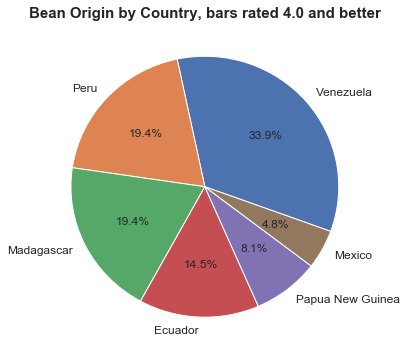

In [55]:
#choc.loc[choc.rating >= 4.0, "orig_of_bean"].value_counts().head(6)
fig, ax = plt.subplots(figsize=[6,6])

# Change this to 3.0 or 3.5 to see how it changes the countries in the pie chart
choc.loc[choc.rating >= 4.0, "orig_of_bean"].value_counts().head(6).plot('pie', autopct='%1.1f%%',
                                                                         fontsize=12, startangle=-20)
plt.ylabel("")
plt.title("Bean Origin by Country, bars rated 4.0 and better", fontsize=15, fontweight='bold')
plt.show()

## 70% is the sweet spot, give or take a couple percentage points

In [56]:
choc.loc[choc.rating >= 4.0, "perc_cocoa"].value_counts().head(10)

70    45
75    17
72    11
74     4
64     4
67     3
63     3
65     2
69     2
68     2
Name: perc_cocoa, dtype: int64

In [20]:
choc.perc_cocoa.describe(include='all')

count    1774.000000
mean       71.735626
std         6.300924
min        46.000000
25%        70.000000
50%        70.000000
75%        75.000000
max       100.000000
Name: perc_cocoa, dtype: float64

## It would be worth looking further into the companies that consistently get top-rated bars, they know what they're doing

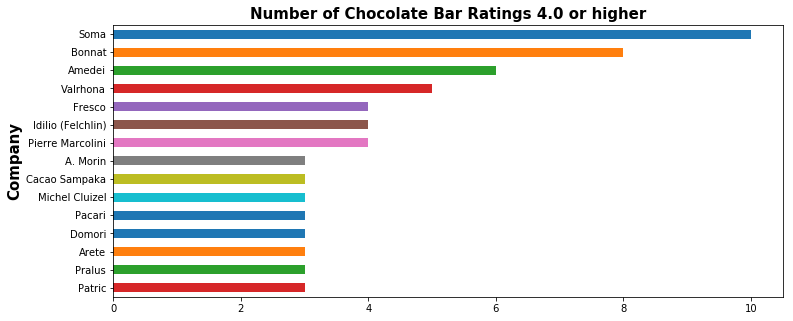

In [21]:
fig, ax = plt.subplots(figsize=[12,5])
choc.loc[choc.rating >= 4.0, "maker"].value_counts().head(15).plot('barh')
plt.title('Number of Chocolate Bar Ratings 4.0 or higher', fontsize=15, fontweight='bold')
plt.ylabel('Company', fontsize=15, fontweight='bold')
plt.gca().invert_yaxis()
plt.show()

## Interesting that there haven't been any ratings of 5 since 2007 (and only 2 overall).  Best to look at a larger set -- 4.0 ratings and better, if you're interested in data about good bars

In [22]:
# Let's look at the very top rated, just for reference
choc.loc[choc.rating >= 5.0]

,maker,orig_of_bar,review_date,perc_cocoa,maker_loc,rating,bean_type,orig_of_bean
78,Amedei,Chuao,2007,70,Italy,5.0,Trinitario,Venezuela
86,Amedei,Toscano Black,2006,70,Italy,5.0,Blend,VARIOUS


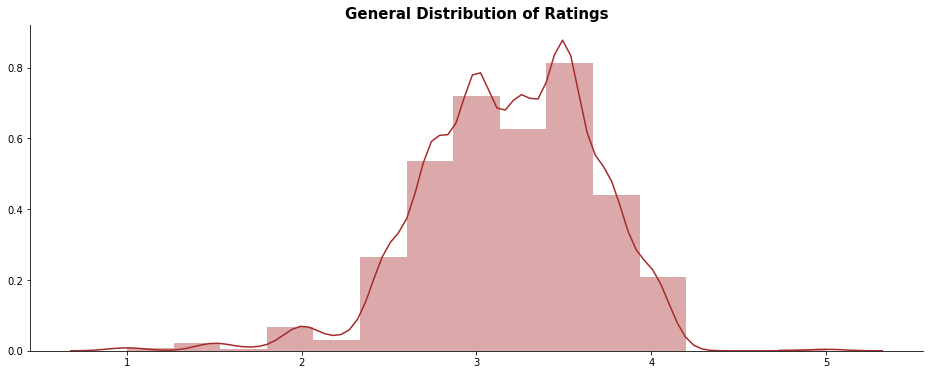

In [23]:
fig, ax = plt.subplots(figsize=[16,6])
sns.distplot(choc['rating'], bins=15, kde=True, color="brown").set_title("General Distribution of Ratings",
                                                                         fontsize=15, fontweight='bold')
ax.set_xlabel("")
sns.despine()
plt.show()

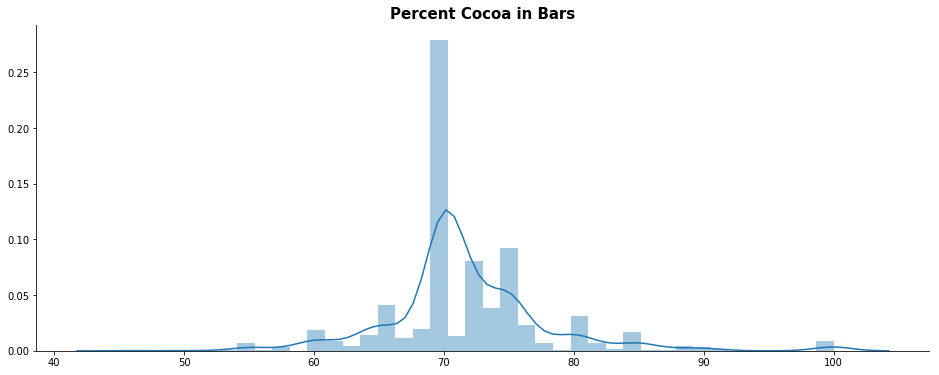

In [24]:
fig, ax = plt.subplots(figsize=[16,6])
sns.distplot(choc['perc_cocoa'], ax=ax, bins=40).set_title("Percent Cocoa in Bars",
                                                           fontsize=15, fontweight='bold')
ax.set_xlabel("")
sns.despine()
plt.show()

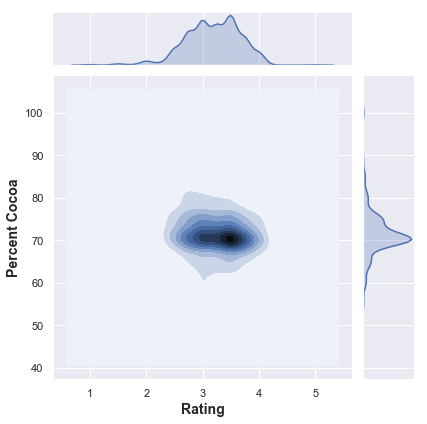

In [25]:
sns.set()
x = choc['rating']
y = choc['perc_cocoa']
sns.jointplot(x, y, kind="kde").set_axis_labels("Rating", "Percent Cocoa", fontsize=14, fontweight='bold')
plt.show()

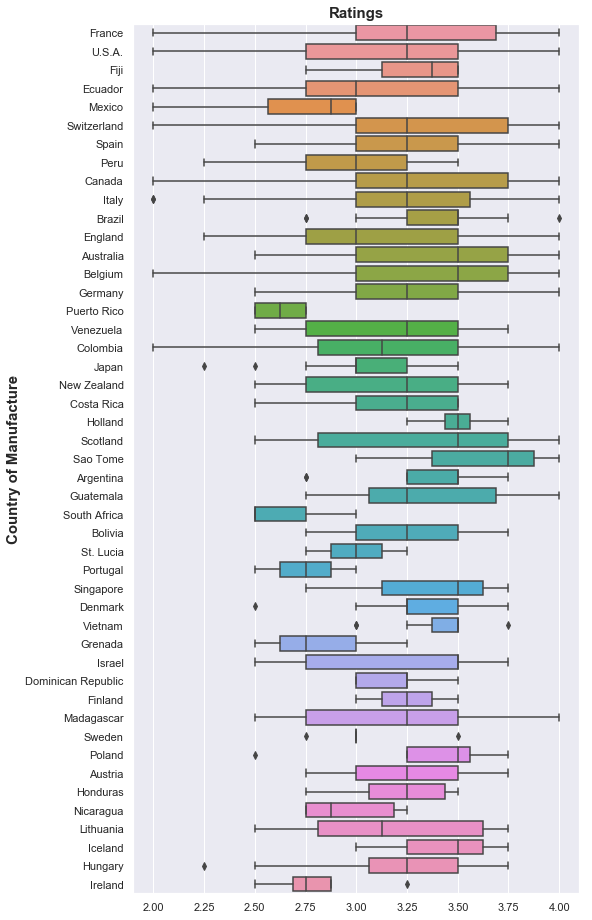

In [26]:
# ratings by country of manufactore
ratings = choc.loc[(choc.rating >= 2.0) & (choc.rating <= 4.0), "rating"]
fig, ax = plt.subplots(figsize=[8, 16])
sns.boxplot(x=ratings, y="maker_loc", data=choc);
ax.set_xlabel("")
ax.set_ylabel("Country of Manufacture", fontsize=15, fontweight='bold')
ax.set_title("Ratings", fontsize=15, fontweight='bold')
plt.show()

# Keep the above in context: look at the number of ratings per country below

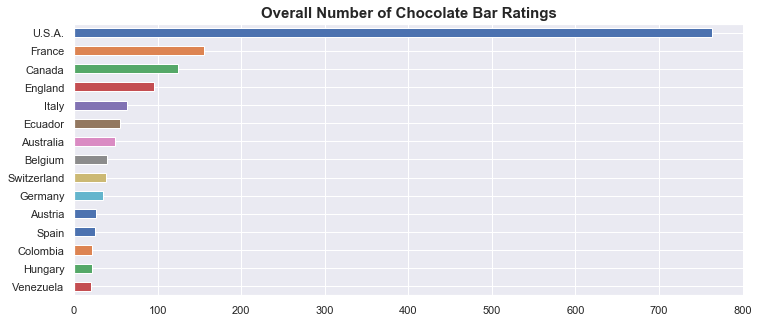

In [27]:
fig, ax = plt.subplots(figsize=[12,5])
choc['maker_loc'].value_counts().head(15).plot('barh')
plt.title('Overall Number of Chocolate Bar Ratings', fontsize=15, fontweight='bold')
plt.gca().invert_yaxis()
plt.show()

# It's a good bet that nearly all the blends are composed of the top 3 varieties, Criollo, Trinitario, and Forastero, and likely focused in the first 2

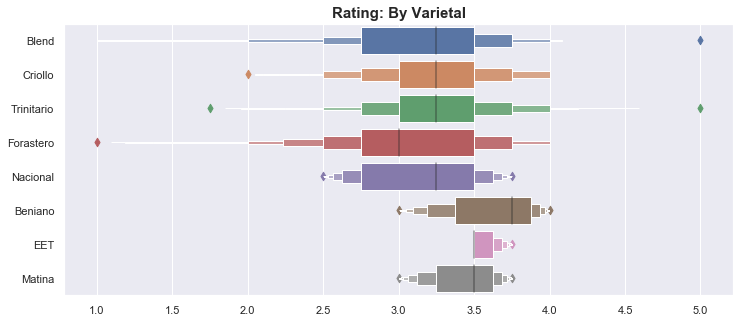

In [28]:
fig, ax = plt.subplots(figsize=[12,5])
sns.boxenplot(x="rating", y="bean_type", data=choc)
ax.set_title("Rating: By Varietal", fontsize=15, fontweight='bold')
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

In [29]:
# Remember these numbers for bean types in top-rated bars; look at 3.0 and 3.5 for further context
choc.loc[choc.rating >= 4.0, "bean_type"].value_counts()

Blend         40
Trinitario    27
Criollo       23
Forastero      9
Beniano        1
Name: bean_type, dtype: int64